In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path



#  1. FUSION DES FICHIERS DE PLUIE 2019–2023 



In [2]:
# dossier contenant tes CSV (ex: 2019.csv, 2020.csv, etc.)
data_path = Path("../data/donnees_pluies")

# liste automatiquement tous les fichiers .csv du dossier
csv_files = list(data_path.glob("*.csv"))

# lecture et concaténation
frames = []
for file in csv_files:
    df = pd.read_csv(file, names=["NO_SICOS", "DATE", "IMPULSION", "STATUT"], header=None)
    frames.append(df)
pluie = pd.concat(frames, ignore_index=True)

print(f"{len(pluie)} enregistrements chargés depuis {len(csv_files)} fichiers")


1137328 enregistrements chargés depuis 2 fichiers


/var/folders/th/9vpk5c6j1j1gdc2dszpnc47r0000gn/T/ipykernel_45423/1275232727.py:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, names=["NO_SICOS", "DATE", "IMPULSION", "STATUT"], header=None)
/var/folders/th/9vpk5c6j1j1gdc2dszpnc47r0000gn/T/ipykernel_45423/1275232727.py:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, names=["NO_SICOS", "DATE", "IMPULSION", "STATUT"], header=None)


# 2. NETTOYAGE ET AGRÉGATION JOURNALIÈRE



In [3]:
pluie["DATE"] = pd.to_datetime(pluie["DATE"], errors="coerce")
pluie = pluie[pluie["STATUT"] == 0]             # capteurs normaux
pluie["jour"] = pluie["DATE"].dt.date
pluie["annee"] = pd.to_datetime(pluie["jour"]).dt.year
pluie["pluie_mm"] = pluie["IMPULSION"] * 0.25   # conversion impulsions -> mm

# Somme journalière par station
jour = (
    pluie.groupby(["NO_SICOS", "jour", "annee"], as_index=False)
         .agg(pluie_mm=("pluie_mm", "sum"))
)


/var/folders/th/9vpk5c6j1j1gdc2dszpnc47r0000gn/T/ipykernel_45423/2264724205.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pluie["DATE"] = pd.to_datetime(pluie["DATE"], errors="coerce")


#  3. CALCUL DES INDICES PAR STATION / ANNÉE 


In [4]:
def compute_indices(group):
    g = group.sort_values("jour").reset_index(drop=True)
    rx1 = g["pluie_mm"].max()
    rx5 = g["pluie_mm"].rolling(5).sum().max()
    r20 = (g["pluie_mm"] >= 20).sum()
    dry = 0
    cdd = 0
    for val in g["pluie_mm"]:
        if val < 1:
            dry += 1
            cdd = max(cdd, dry)
        else:
            dry = 0
    tot = g["pluie_mm"].sum()
    return pd.Series({
        "Rx1day_mm": rx1,
        "Rx5day_mm": rx5,
        "R20mm_jour": r20,
        "CDD_jour": cdd,
        "precip_totale_annuelle": tot
    })

indices = (
    jour.groupby(["NO_SICOS", "annee"])
        .apply(compute_indices)
        .reset_index()
)

/var/folders/th/9vpk5c6j1j1gdc2dszpnc47r0000gn/T/ipykernel_45423/1493427187.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_indices)


# 4. AJOUT DES COORDONNÉES DES STATIONS


In [5]:
loc = pd.read_csv("../data/Pluviomètres_localisation.csv")  # contient NO_SICOS, LAT, LON ou MTM8
indices = indices.merge(loc, on="NO_SICOS", how="left")


# 5. CONVERSION EN COUCHE GEO 


In [6]:
indices["geometry"] = [Point(xy) for xy in zip(indices["LONGITUDE"], indices["LATITUDE"])]
gdf = gpd.GeoDataFrame(indices, geometry="geometry", crs="EPSG:4326")

# 6. EXPORT 


In [7]:
gdf.to_file("../outputs/indices_pluviometriques_2019_2023.gpkg", driver="GPKG")

print("✅ Fichier 'indices_pluviometriques_2019_2023.gpkg' créé avec succès.")


✅ Fichier 'indices_pluviometriques_2019_2023.gpkg' créé avec succès.


# 7. Visualisation

In [14]:


import geopandas as gpd
import matplotlib.pyplot as plt

# Lecture du fichier GeoPackage final
gdf = gpd.read_file("../outputs/indices_pluviometriques_2019_2023.gpkg")

# Aperçu des 10 premières lignes
print("Aperçu des indices pluviométriques :")
print(gdf.head(10))

# Info sur les colonnes et les types
print("\nStructure des données :")
print(gdf.info())



Aperçu des indices pluviométriques :
   NO_SICOS  annee  Rx1day_mm  Rx5day_mm  R20mm_jour  CDD_jour  \
0  OBFT1011   2024      25.00      31.50         1.0       2.0   
1  OBFT1021   2024      27.00      34.50         1.0       1.0   
2  OBFT1031   2024      26.25      40.50         1.0       1.0   
3  OBFT1041   2024      31.75      42.00         1.0       0.0   
4  OBFT1051   2024      18.50      44.25         0.0       1.0   
5  OBFT1061   2024      20.50      43.50         1.0       0.0   
6  OBFT1081   2024      25.00      50.25         1.0       0.0   
7  OBFT1091   2024      21.50      37.75         1.0       0.0   
8  OBFT1101   2024      20.50      36.00         1.0       0.0   
9  OBFT1111   2024      25.25      43.25         1.0       0.0   

   precip_totale_annuelle        MTM8_X        MTM8_Y   LATITUDE  LONGITUDE  \
0                   38.50  263682.25305  5.028076e+06  45.391421 -74.025129   
1                   41.00  269635.27279  5.028869e+06  45.398880 -73.949160   

# 1. Nettoyage

In [15]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler


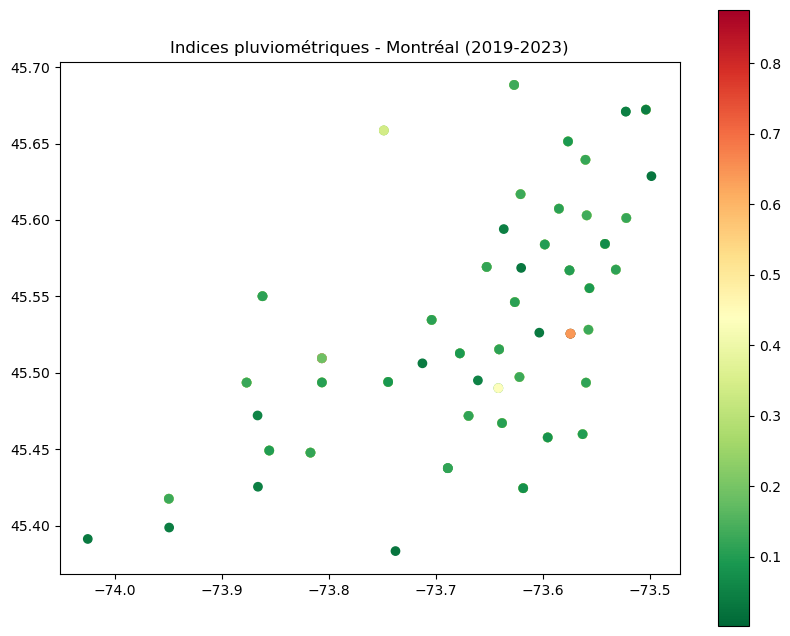

✅ Fichier nettoyé enregistré : indices_pluviometriques_nettoye.gpkg


In [18]:

# --- 1. Charger le fichier GPKG ---
gdf = gpd.read_file("../outputs/indices_pluviometriques_2019_2023.gpkg")

# --- 2. Nettoyage de base ---
gdf = gdf.drop_duplicates()
gdf = gdf.dropna(subset=["precip_totale_annuelle", "Rx1day_mm", "Rx5day_mm", "R20mm_jour"])

# --- 3. Harmoniser les noms de colonnes ---
gdf = gdf.rename(columns={
    "Rx1day_mm": "max_1j",
    "Rx5day_mm": "max_5j",
    "R20mm_jour": "jours_>20mm",
    "precip_totale_annuelle": "precip_annuelle"
})

# --- 4. Normalisation des indices ---
cols = ["precip_annuelle", "max_1j", "max_5j", "jours_>20mm"]
scaler = MinMaxScaler()
gdf[cols] = scaler.fit_transform(gdf[cols])

# --- 5. Calcul du score global d’exposition pluviale ---
gdf["precip_intense"] = (
    0.4 * gdf["max_1j"] +
    0.3 * gdf["max_5j"] +
    0.2 * gdf["jours_>20mm"] +
    0.1 * gdf["precip_annuelle"]
)

#visualisation rapide
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column="precip_intense", cmap="RdYlGn_r", legend=True, ax=ax)
ax.set_title("Indices pluviométriques - Montréal (2019-2023)")
plt.show()

# --- 6. Sauvegarde du résultat ---
gdf.to_file("../outputs/indices_pluviometriques_nettoye.gpkg", driver="GPKG")

print("✅ Fichier nettoyé enregistré : indices_pluviometriques_nettoye.gpkg")

### Observation — Indices pluviométriques à Montréal (2019-2023)

La carte présente la répartition spatiale des indices pluviométriques moyens sur l’île de Montréal entre 2019 et 2023.  
On observe une **prépondérance de valeurs faibles à modérées** (points verts), indiquant une pluviométrie généralement stable.  
Quelques **zones ponctuelles de forte intensité** (points jaunâtres à rougeâtres) apparaissent, principalement vers le **centre-est de la ville** (autour de -73.6° de longitude).  
Ces zones concentrent les épisodes pluvieux les plus marqués, susceptibles d’amplifier les risques locaux de ruissellement ou d’inondation urbaine.
